In [1]:
## import required packages
import os, math, sys
import numpy as np
import matplotlib.pyplot as plt
import openmm.app  as omm_app
import openmm as omm
import openmm.unit as unit
from tqdm import tqdm
# import mdtraj
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
from MDAnalysis.analysis.dihedrals import Dihedral

/Users/shashanksule/miniforge3/envs/mdenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/shashanksule/miniforge3/envs/mdenv/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


In [2]:
import torch.nn as nn
import torch

In [3]:
def dihedral_angle_torch(x):
    # get dihedral angle
    carbons = x[[3,6,9,13],:]
    vectors = carbons[1:,:] - carbons[:-1,:]
    na = torch.cross(-vectors[0,:], vectors[1,:])
    nb = torch.cross(-vectors[1,:], vectors[2,:])
    xx = torch.dot(na.flatten(), nb.flatten())
    xp = torch.cross(na,nb)
    yy = torch.dot(vectors[1,:].flatten(),xp.flatten())/torch.norm(vectors[1,:])
    angle = torch.atan2(yy,xx)
    return angle
def dihedral_angle_cos(x):
    return torch.cos(dihedral_angle_torch(x))
def dihedral_angle_sin(x):
    return torch.sin(dihedral_angle_torch(x))

# Set up system + Sim params

In [4]:
# Indicates whether to run a simulation or not
SIMULATE = False
device = "cuda:0"

In [7]:
psf = omm_app.CharmmPsfFile('../../data/butane.psf')
pdb = omm_app.PDBFile('../../data/butane.pdb')
topology = psf.topology

In [9]:
params = omm_app.CharmmParameterSet('../../data/top_all35_ethers.rtf',
                                    '../../data/par_all35_ethers.prm')

In [10]:
system = psf.createSystem(params, nonbondedMethod=omm_app.NoCutoff)
## add a harmonic biasing potential on butane dihedral to the OpenMM system
# bias_torsion = omm.CustomTorsionForce("0.5*K*dtheta^2; dtheta = min(diff, 2*Pi-diff); diff = abs(theta - theta0)")
bias_torsion = omm.CustomTorsionForce("0.5*K*diffc^2 + 0.5*K*diffs^2; diffc = abs(cos(theta) - c); diffs = abs(sin(theta) - s)")
bias_torsion.addGlobalParameter("Pi", math.pi)
bias_torsion.addGlobalParameter("K", 1.0)
bias_torsion.addGlobalParameter("c", -1.0)
bias_torsion.addGlobalParameter("s", 0.0)
## 3, 6, 9, 13 are indices of the four carton atoms in butane, between which
## the dihedral angle is biased.
bias_torsion.addTorsion(3, 6, 9, 13)
system.addForce(bias_torsion)

8

In [11]:
# ## read the OpenMM system of butane
# with open("../output/system.xml", 'r') as file_handle:
#     xml = file_handle.read()
# system = omm.XmlSerializer.deserialize(xml)

## read psf and pdb file of butane
psf = omm_app.CharmmPsfFile("../../data/butane.psf")
pdb = omm_app.PDBFile('../../data/butane.pdb')
topology = psf.topology

# Get data for centering bias potential

In [12]:
# angles = np.linspace(-np.pi, -np.pi, 100)

In [8]:
#### setup an OpenMM context

## platform
platform = omm.Platform.getPlatformByName('CUDA')

## integrator
T = 300 * unit.kelvin  ## temperature
kbT = unit.BOLTZMANN_CONSTANT_kB * T * unit.AVOGADRO_CONSTANT_NA 
kbT = kbT.value_in_unit(unit.kilojoule_per_mole)
fricCoef = 10/unit.picoseconds ## friction coefficient
stepsize = 2 * unit.femtoseconds ## integration step size
integrator = omm.LangevinMiddleIntegrator(T, fricCoef, stepsize)

## construct an OpenMM context
context = omm.Context(system, integrator, platform)

In [9]:
## set force constant K for the biasing potential.
## the unit here is kJ*mol^{-1}*nm^{-2}, which is the default unit used in OpenMM
K = 500
context.setParameter("K", K)

## M centers of harmonic biasing potentials
# M = 10
# # theta0 = np.linspace(-math.pi, math.pi, M, endpoint = False)
# cs = np.linspace(-1.0, 1.0, M)
# ss = np.linspace(-1.0, 1.0, M)
# np.savetxt("./output/dihedral_TPT/theta0.csv", theta0, delimiter = ",")

In [28]:
traj = mda.Universe("../../data/butane.psf", "traj.dcd")
full_traj = traj.trajectory.timeseries(traj.atoms)
subsampled_traj = torch.permute(torch.Tensor(full_traj[:,::1,:]),(1,0,2))

In [13]:
CV_space = []
angles = []
for i in tqdm(range(subsampled_traj.shape[0])): 
    cos_angle = dihedral_angle_cos(subsampled_traj[i,:,:].squeeze(0))
    sin_angle = dihedral_angle_sin(subsampled_traj[i,:,:].squeeze(0))
    angle = dihedral_angle_torch(subsampled_traj[i,:,:].squeeze(0))
    CV_space.append(np.array([sin_angle, cos_angle])) # weird convention due to sampling
    angles.append(angle)
CV_space = np.array(CV_space) 
angles = np.array(angles)

100%|██████████| 10/10 [00:00<00:00, 1274.17it/s]


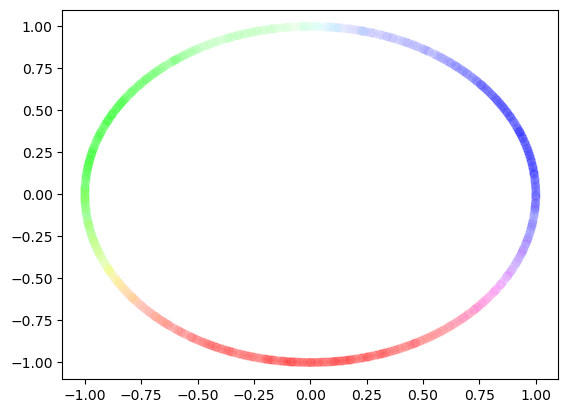

In [12]:
# visualize
plt.scatter(CV_space[:,0], CV_space[:,1], c=angles, cmap='hsv', alpha=0.005)

# Now run the simZ! 

In [ ]:
## the main loop to run umbrella sampling window by window
for index in tqdm(range(CV_space.shape[0])):
        ## set the center of the biasing potential
        context.setParameter("c", CV_space[index,1])
        context.setParameter("s", CV_space[index, 0])
        
        ## minimize
        context.setPositions(pdb.positions)
        state = context.getState(getEnergy = True)
        energy = state.getPotentialEnergy()
        for i in range(50):
            omm.LocalEnergyMinimizer.minimize(context, 1, 20)
            state = context.getState(getEnergy = True)
            energy = state.getPotentialEnergy()
    
        ## initial equilibrium
        integrator.step(5000)
    
        ## sampling production. trajectories are saved in dcd files
        file_handle = open(f"../output/dihedral_TPT/short_traj/traj_{index}.dcd", 'bw')
        dcd_file = omm_app.dcdfile.DCDFile(file_handle, psf.topology, dt = stepsize)
        for i in range(300):
            integrator.step(100)
            state = context.getState(getPositions = True)
            positions = state.getPositions()
            dcd_file.writeModel(positions)
        file_handle.close()

 26%|█████████▎                          | 3158/12254 [57:27<2:41:03,  1.06s/it]

In [20]:
## the main loop to run umbrella sampling window by window
for theta0_index in tqdm(range(M)):
    # print(f"sampling at theta0 index: {theta0_index} out of {M}")

    ## set the center of the biasing potential
    context.setParameter("theta0", theta0[theta0_index])

    ## minimize
    context.setPositions(pdb.positions)
    state = context.getState(getEnergy = True)
    energy = state.getPotentialEnergy()
    for i in range(50):
        omm.LocalEnergyMinimizer.minimize(context, 1, 20)
        state = context.getState(getEnergy = True)
        energy = state.getPotentialEnergy()

    ## initial equilibrium
    integrator.step(5000)

    ## sampling production. trajectories are saved in dcd files
    file_handle = open(f"../output/dihedral_TPT/short_traj/traj_{theta0_index}.dcd", 'bw')
    dcd_file = omm_app.dcdfile.DCDFile(file_handle, psf.topology, dt = stepsize)
    for i in range(300):
        integrator.step(100)
        state = context.getState(getPositions = True)
        positions = state.getPositions()
        dcd_file.writeModel(positions)
    file_handle.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:40<00:00,  1.12s/it]


# Upload dihedral angle model for diff.tensor compute

In [16]:
M = []
for index in tqdm(range(CV_space.shape[0])):
        short_traj = mda.Universe("../data/butane.psf", f"../output/dihedral_TPT/short_traj/traj_{index}.dcd")
        coords = torch.permute(torch.Tensor(short_traj.trajectory.timeseries(short_traj.atoms)),(1,0,2))
        # set up jacobians 
        jmat1 = torch.zeros(coords.shape)
        jmat2 = torch.zeros(coords.shape)
        for j in range(300):
            jmat1[j,:,:] = torch.autograd.functional.jacobian(dihedral_angle_cos, coords[j,:,:])
            jmat2[j,:,:] = torch.autograd.functional.jacobian(dihedral_angle_sin, coords[j,:,:])
    
        # compute diff tensor 
        diff_tensor = (1/300)*torch.tensor([[torch.sum(jmat1*jmat1), torch.sum(jmat1*jmat2)], [torch.sum(jmat2*jmat1), torch.sum(jmat2*jmat2)]])
        M.append(diff_tensor.numpy())

100%|█████████████████████████████████████| 12254/12254 [46:31<00:00,  4.39it/s]


In [14]:
diff_tensor_dic = np.load('diffusion_tensors_cossin.npz', allow_pickle=True)
data, diffusion_tensors = diff_tensor_dic['data'], diff_tensor_dic['diffusion_tensors']

In [15]:
for i in range(diffusion_tensors.shape[0]): 
    dcos_squared = diffusion_tensors[i,0,0]
    dsin_squared = diffusion_tensors[i,1,1]
    diffusion_tensors[i,0,0] = dsin_squared
    diffusion_tensors[i,1,1] = dcos_squared

In [16]:
subsampled_M = diffusion_tensors[::100,:,:]
subsampeld_data = data[::100,:] 

(-1.2, 1.2)

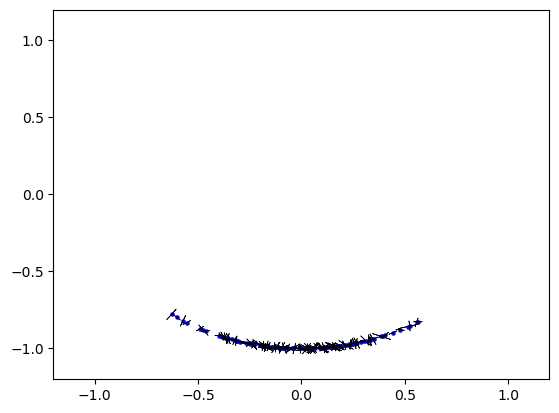

In [17]:
plot_scale = 1e-2
i=0
for index in range(subsampled_M.shape[0]):
        # if final_angles[i] >= 2.5:
        cov = subsampled_M[i,:,:]
        evals, evecs = np.linalg.eig(cov)
        idx = evals.argsort()[::-1]
        evals = evals[idx]
        evecs = evecs[:, idx]
        t = np.linspace(0, 2*np.pi)
        val = plot_scale*evecs*evals
        x = data[i,:]
        # x = np.array([cs[c], ss[s]])
        # x = CV_space[index,:]
        # print(f'{x}')
        a = np.dot(val, np.vstack([np.cos(t), np.sin(t)]))
        plt.plot(a[0, :] + x[0], a[1, :] + x[1], linewidth=0.5, c='k')
        plt.scatter(x[0], x[1], color='b', s=5.0)
        i = i+1
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])

In [20]:
# visualize each component
angles = np.arctan2(data[:,0],data[:,1])

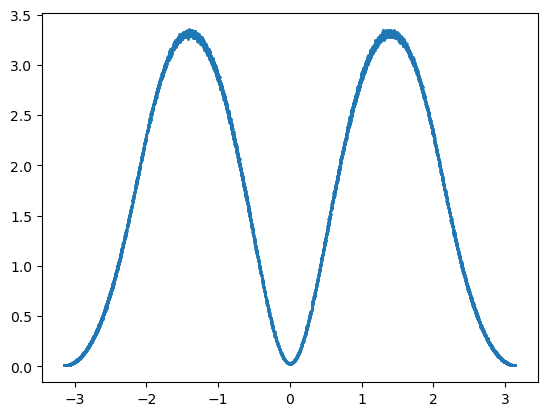

In [25]:
plt.scatter(angles, diffusion_tensors[:,0,0], s=1.0)